# Score matching flow

In [1]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models
import flows

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Main

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


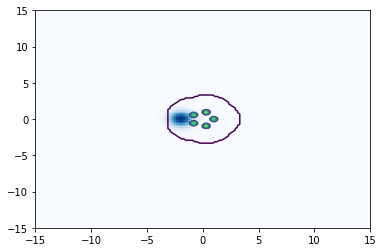

In [2]:
%matplotlib inline
setup = distributions.mix_of_gauss
target, proposal = setup.get()
setup.plot(lims=(-15, 15))

In [3]:
%autoreload

In [55]:
n_steps = 200
noise = 1.
particle_lr = 5e-2
n_particles = 100
key, subkey = random.split(key)
neural_learner, neural_particles, err = flows.neural_score_flow(subkey, setup, n_steps=n_steps, particle_lr=particle_lr, noise_level=noise, sizes=[32, 32, 2], patience=5, n_particles=n_particles)
# kernel_gradient, kernel_particles, err =       flows.score_flow(subkey, setup, n_steps=n_steps, particle_lr=particle_lr, noise_level=noise)
svgd_gradient, svgd_particles, err            = flows.svgd_flow(subkey, setup, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True, n_particles=n_particles)

100%|██████████| 200/200 [00:02<00:00, 69.33it/s]


## Plot

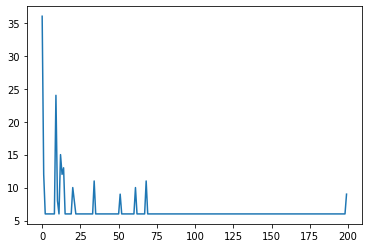

In [56]:
%matplotlib inline
n_steps = neural_learner.rundata["train_steps"]
plt.plot(n_steps)

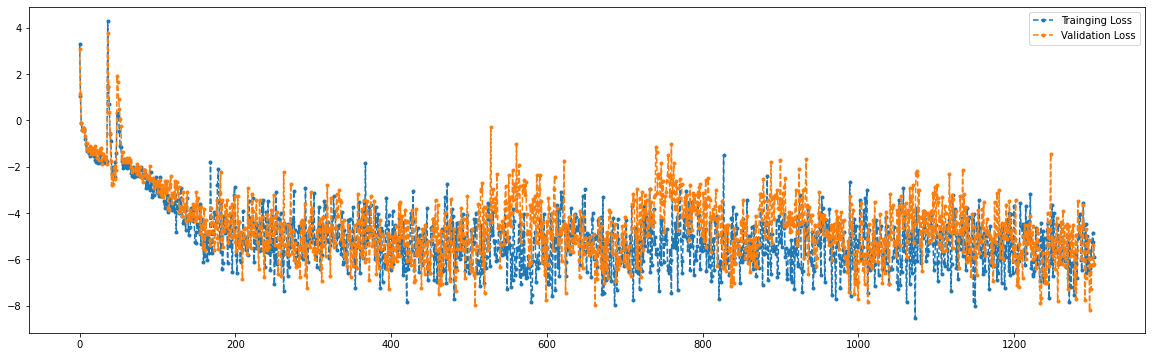

In [57]:
%matplotlib inline
plt.subplots(figsize=[20, 6])
plt.plot(neural_learner.rundata["training_loss"], "--.", label="Trainging Loss")
plt.plot(neural_learner.rundata["validation_loss"], "--.", label="Validation Loss")
plt.legend()

Text(0.5, 1.0, 'True Samples')

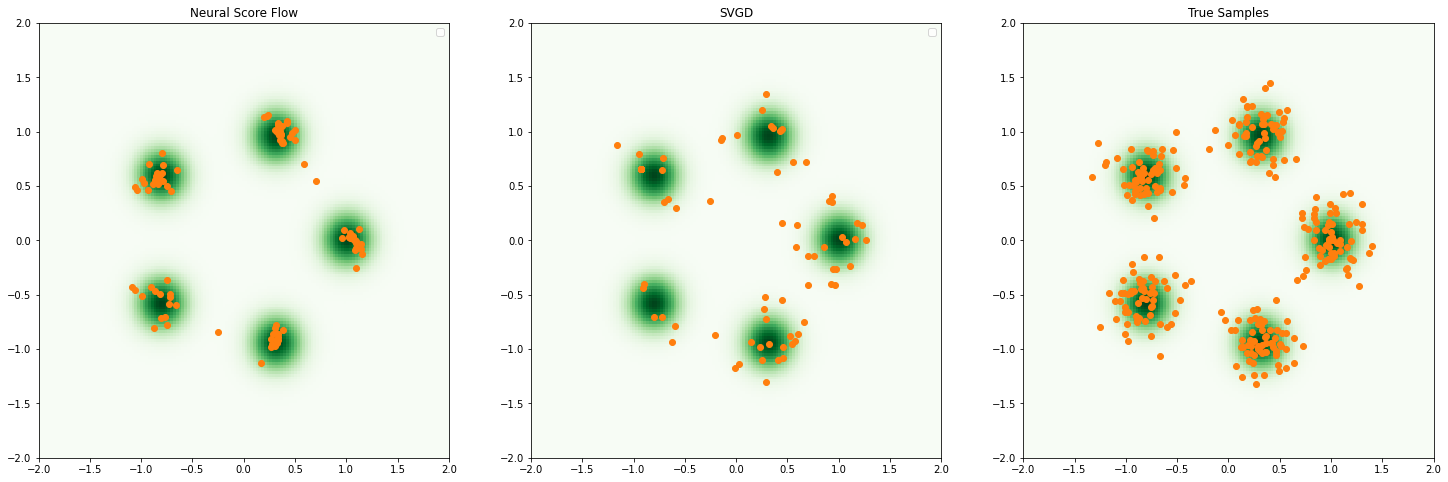

In [64]:
%matplotlib inline
lim = (-2, 2)
fig, axs = plt.subplots(1, 3, figsize=[25, 8])
axs = axs.flatten()
for ax in axs:
    ax.set(xlim=lim, ylim=lim)
ax1 = neural_particles.plot_final(ax=axs[0], target=target, cmap="Greens", idx=neural_particles.group_idx[0])
ax1.set_title("Neural Score Flow")

ax2 = svgd_particles.plot_final(ax=axs[1], target=target, cmap="Greens", idx=neural_particles.group_idx[0])
ax2.set_title("SVGD")

ax = axs[2]
plot.plot_fun_2d(target.pdf, lims=lim, ax=ax, cmap="Greens")
plot.scatter(target.sample(300), ax=ax, color="tab:orange")
ax.set_title("True Samples")

In [81]:
neural_trajectories = np.asarray(neural_particles.rundata["particles"])[:, neural_particles.group_idx[0]]
# kernel_trajectories = np.asarray(kernel_particles.rundata["particles"])
svgd_trajectories = np.asarray(svgd_particles.rundata["particles"])[:, svgd_particles.group_idx[0]]

In [82]:
%matplotlib widget
fig, axs = plt.subplots(1, 2, figsize=[14, 6])
axs=axs.flatten()
lim=(-2, 2)
for ax in axs:
    ax.set(xlim=lim, ylim=lim)

animations = []
for ax, trajectories, title in zip(axs, [neural_trajectories, svgd_trajectories], ["Neural", "SVGD"]):
    ax.set_title(title)
    plot.plot_fun_2d(target.pdf, lims=lim, ax=ax)
    animations.append(plot.animate_array(trajectories, fig, ax))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


In [61]:
p = svgd_particles.rundata["particles"][-1][svgd_particles.group_idx[0]]
metrics.compute_final_metrics(p, target)

{'emd': DeviceArray(0.39628544, dtype=float32),
 'ksd': DeviceArray(-0.79522794, dtype=float32),
 'se_mean': DeviceArray(0.01488711, dtype=float32),
 'se_var': DeviceArray(0.00134947, dtype=float32)}

In [62]:
p, *_ = svgd_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(p, target)

{'emd': DeviceArray(0.36951864, dtype=float32),
 'ksd': DeviceArray(-0.86552536, dtype=float32),
 'se_mean': DeviceArray(0.01361411, dtype=float32),
 'se_var': DeviceArray(0.00141905, dtype=float32)}

In [63]:
p, *_ = neural_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(p, target)

{'emd': DeviceArray(0.467803, dtype=float32),
 'ksd': DeviceArray(0.62556905, dtype=float32),
 'se_mean': DeviceArray(0.01008052, dtype=float32),
 'se_var': DeviceArray(0.00021914, dtype=float32)}